# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [3]:
# importing data;
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')   

In [4]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
print(train_df.shape[0])

3662


# **#Image preproccesing section 
Two activities are included in the pre-processing of an image: 
resizing (tf_load_process_image size = 224x224) and converting an image to numpy arrays (immage_array)

In [5]:

def tf_load_process_image(filename):
  img_size = 224
  # Load image (in PIL image format by default)
  image_original = load_img(filename, target_size=(img_size, img_size))

  # Convert from numpy array
  image_array = img_to_array(image_original)

  # Expand dims to add batch size as 1
  image_batch = np.expand_dims(image_array, axis=0)

  # Preprocess image
  image_preprocessed = tf.keras.applications.vgg16.preprocess_input(image_batch)

  return  image_preprocessed
img_size = 224
x_train = np.empty((train_df.shape[0], img_size, img_size, 3), dtype=np.uint8)
x_test = np.empty((test_df.shape[0], img_size, img_size, 3), dtype=np.uint8)

for i, image_id in enumerate((train_df['id_code'])):
   x_train[i, :, :, :] = tf_load_process_image(f'/kaggle/input/aptos2019-blindness-detection/train_images/{image_id}.png')
for i, image_id in enumerate((test_df['id_code'])):
   x_test[i, :, :, :] = tf_load_process_image(f'/kaggle/input/aptos2019-blindness-detection/test_images/{image_id}.png')   


In [6]:
print("x_train.shape=",x_train.shape)
print("x_test.shape=",x_test.shape)
x_train.shape[3]

x_train.shape= (3662, 224, 224, 3)
x_test.shape= (1928, 224, 224, 3)


3

In [7]:
cd /kaggle


/kaggle


# Prepare test data
# One-hot encoding the labels
Although label encoding is straightforward, it has the drawback that algorithms may mistakenly read the numeric numbers as containing some form of hierarchy or order. Another prominent alternate strategy called "One-Hot Encoding" addresses this ordering problem. Using this method, each category value is transformed into a new column and given a 1 or 0 (true/false) value. Let's go back to the bridge type and safety level example from before using one-hot encoding.


In [8]:
from sklearn.preprocessing import LabelBinarizer
import pickle
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(train_df['diagnosis'])
pickle.dump(label_binarizer,open('/label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
print("y_train.shape=",image_labels.shape)


y_train.shape= (3662, 5)


# Using data generator
To reduce overfitting, we use the data augmentation strategy on the training set. It features a 5 degree picture rotation, 900% width and 50% height shifts, and a horizontal flip. The ImageDataGenerator function in the keras.preprocessing.image module has an impact on these methods.


In [10]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [11]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [12]:
from sklearn.model_selection import train_test_split

x_train1, x_val, y_train, y_val = train_test_split(x_train, image_labels, test_size=0.15, random_state = 42)

In [14]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=5

n_steps = x_train1[0].size // BATCH_SIZE
n_val_steps = x_val[0].size // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [15]:
pwd

'/kaggle'

In [16]:


# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import keras
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D

class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses1 = TrainingPlot()

In [18]:
%%time 

vgg_history = vgg_model.fit(train_generator.flow(x_train1, y_train),
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=(x_val, y_val),
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_losses1],
                            verbose=1)

2022-12-28 03:13:16.862835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-28 03:13:19.523039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  98/2352 [>.............................] - ETA: 18:02 - loss: 6.6535 - accuracy: 0.5537

2022-12-28 03:14:18.861325: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 82790400 exceeds 10% of free system memory.
2022-12-28 03:14:18.973711: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 82790400 exceeds 10% of free system memory.


2352/2352 [==============================] - 83s 29ms/step - loss: 6.6535 - accuracy: 0.5537 - val_loss: 1.8286 - val_accuracy: 0.6527

Epoch 00001: val_loss improved from inf to 1.82858, saving model to tl_model_v1.weights.best.hdf5


2022-12-28 03:14:39.864766: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2022-12-28 03:14:40.998733: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2022-12-28 03:14:41.707482: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


CPU times: user 1min 19s, sys: 7.77 s, total: 1min 27s
Wall time: 1min 32s


In [19]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

y_test = vgg_model.predict(x_test)
rng = int(y_test.size/5)

    
ss = pd.DataFrame(columns=['id_code', 'diagnosis'])
for i in range(rng):
    ss = pd.concat([pd.DataFrame([[test_df.iloc[i:i+1]['id_code'][i],[np.argmax(y_test[i])][0]]], columns=ss.columns), ss], ignore_index=True)

In [22]:
cd /kaggle/working


/kaggle/working


In [23]:
pwd

'/kaggle/working'

In [25]:
maindir = "/kaggle/working"
ss.to_csv(maindir+"/submission.csv", index=False)

In [26]:
ss

,id_code,diagnosis
0,ffdc2152d455,0
1,ffa73465b705,1
2,ff64897ac0d8,2
3,ff4c945d9b17,2
4,ff2fd94448de,2
...,...,...
1923,009245722fa4,2
1924,00836aaacf06,2
1925,006efc72b638,2
1926,003f0afdcd15,2


In [32]:
vgg_history.history

{'loss': [6.6534953117370605],
 'accuracy': [0.5536632537841797],
 'val_loss': [1.828583836555481],
 'val_accuracy': [0.6527272462844849]}

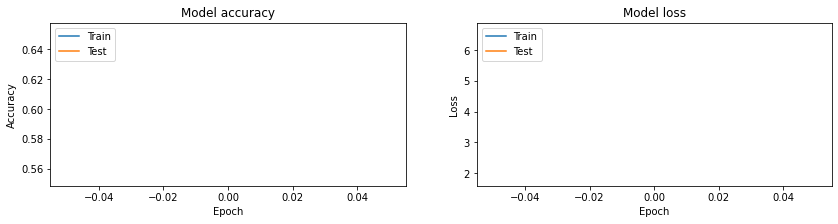

In [31]:
from matplotlib import pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import keras
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D

class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

# Comparison of Trained Models to Accuracy
# 
Accuracy graph was created to compare the accuracy of different models trained in the project. ​ ​


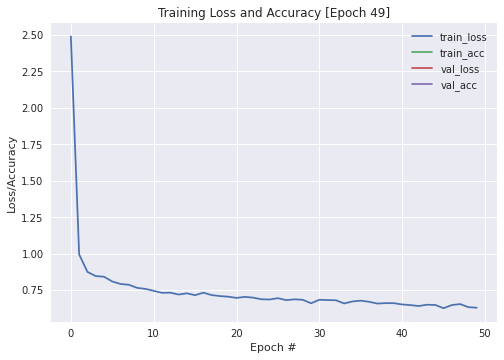

In [38]:

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(train_generator.flow(x_train1, y_train),
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=(x_val, y_val), 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_losses],
                                  verbose=1)

In [41]:
cd ..

/kaggle


In [49]:
ls

input/  lib/  model.h5  tl_model_v1.weights.best.hdf5  working/


In [50]:
cp  model.h5 /kaggle/working

In [52]:
from IPython.display import FileLink
FileLink(r'model.h5')

/kaggle/model.h5

In [43]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights


y_test = vgg_model.predict(x_test)
rng = int(y_test.size/5)

    
ss = pd.DataFrame(columns=['id_code', 'diagnosis'])
for i in range(rng):
    ss = pd.concat([pd.DataFrame([[test_df.iloc[i:i+1]['id_code'][i],[np.argmax(y_test[i])][0]]], columns=ss.columns), ss], ignore_index=True)

In [48]:
vgg_model_ft.save("model.h5")

In [45]:
ss

,id_code,diagnosis
0,ffdc2152d455,0
1,ffa73465b705,1
2,ff64897ac0d8,2
3,ff4c945d9b17,2
4,ff2fd94448de,2
...,...,...
1923,009245722fa4,2
1924,00836aaacf06,2
1925,006efc72b638,2
1926,003f0afdcd15,2


In [ ]:
maindir = "/kaggle/working"
ss.to_csv(maindir+"/submission.csv", index=False)